# Classfication of Mushroom Edibility

## Problem Statement
> **Develop a Classfication Model to Predict If A Given Mushroom Is Safe For Consumption**

We want an accurate model that can be used in the field to help people determine if a gilled mushroom is edible. 
### What does human level performance look like for this problem? 
In a article published in Feburary 2020, the [US Agricultural Research Service developed a portable test](https://www.mdpi.com/2072-6651/12/2/123/htm) to detect if a mushroom is poisonous.

| Accuracy | True Positive Rate (Recall) | True Negative Rate |
|----|----|----|
| 94.6% | 92.3% | 100% |

Since we want a model that can be easily used in the field, and without any lab equipment, we will make this test as the benchmark to match/beat.
## Evaluation Metrics

### Optimizing Metric 
In this problem, it is far more important that our model has a high positive predictive power as we care more about detecting if a mushroom is poisonous than if it is edible. Hence, we aim to make use of a classification metric that heavily penalizes our model for making false negatives.
#### F2 Score
The $F_2$ Score is defined as follows:
$$
F_2 = 5 * \frac{precision*recall}{(4 * precision) + recall} = \frac{TP}{TP + 0.2*FP + 0.8FN}
$$

The F2 measure is a single number that summarizes the precision and recall of a model, placing more emphasis on the recall of the model. Since recall (the ability of a model to predict the positive class) is more important in this problem, an F2 Score would be a useful indicator of the utility of a candidate model. 
### Satisficing Metrics

#### Model Interpretibility
Given that the objective of the model is to help decide if a mushroom is poisonous, it is important that the human using the model is able to understand why the model has made a certain prediction, for him to make a final decision. Hence, the model used must not be a black box, but rather expose the factors that affect the final prediction. This means that we will avoid black box models such as ANNs, and prefer models like Logistic Regression or Decision Trees.

#### Overall Accuracy
Although we seek to maximize the $F_2$ score, the overall model should have an accuracy **above 95%** as we want the model to also be relatively good at predicting the negative class.

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import phik
import json
from tqdm import tqdm
sns.set()

# Experimental
from sklearn.experimental import enable_halving_search_cv

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve, feature_importances
from sklearn.inspection import permutation_importance

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer


# Models
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

## Data Ingestion
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [2]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [3]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Exploration

In [4]:
mush_eda = mush_df.copy()

### Univariate Analysis

#### Descriptive Statistics

In [5]:
mush_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

We note that all features are nominally valued categorical features. Only stalk-root has missing values, with around 37.5% of the rows having stalk root as missing. We will need to investigate this more later to determine why the value is missing.

In [11]:
descriptive_stats = mush_eda.describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(mush_eda) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
veil-type,8124,1,partial,8124,100.0
veil-color,8124,4,white,7924,97.538159
gill-attachment,8124,2,free,7914,97.415066
ring-number,8124,3,one,7488,92.171344
gill-spacing,8124,2,close,6812,83.85032
gill-size,8124,2,broad,5612,69.079271
stalk-surface-above-ring,8124,4,smooth,5176,63.712457
stalk-surface-below-ring,8124,4,smooth,4936,60.758247
bruises?,8124,2,f,4748,58.444116
stalk-shape,8124,2,tapering,4608,56.720827


From looking at the most frequent value of each column, we note that:
- most mushrooms are edible, and the classes appear to be balanced
- `veil-Type` has only a single value for all observations. 
- `gill-color` is the most varied feature, with 12 unique values, followed by `cap-color` with 10 values 
- almost all mushrooms have a white colored veil 

#### Target Label
Our target label is the `class` column. It is a binary column with two values:
- `edible`: Mushroom is safe to eat
- `poisonous`: Mushroom is of dubious edibility or straight up poisonous

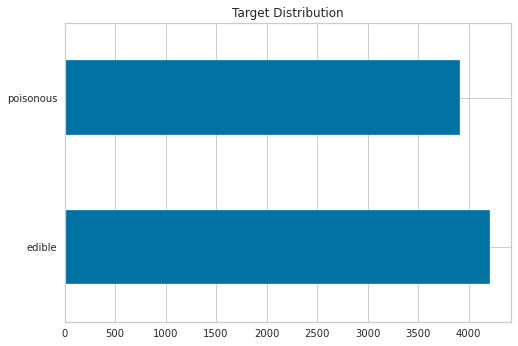

In [18]:
ax = mush_eda["class"].value_counts().plot(kind='barh', title="Target Distribution")

As we can see, the class distribution is relatively balanced, with most mushrooms being edible. Slightly less mushrooms are poisonous.

#### Features

In [19]:
features = set(mush_eda.columns) - {"class"}

In [20]:
def cat_plot(df, features, hue = None, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        counts = df[feature].value_counts().sort_values(ascending=False)
        if hue is None:
            sns.countplot(data = df, y = feature, ax = ax[idx], order= counts.index)
        else:
            sns.countplot(data = df, y = feature, hue= hue, ax = ax[idx], order= counts.index)
    return fig

##### General Features
###### Spore Print Color
- The spore print is the powdery deposit obtained by allowing spores of the mushroom to fall onto a surface underneath. 
- It is an essential clue to the identity of many species of mushrooms. 
- Individual spores are too small to be visible without a microscope. Hence other techniques must be used to obtain this data.
- One way is to cut off the head of the mushroom, and place it with the gills (below the cap) facing downward on a white sheet of paper. 
![How to make a spore print](https://github.com/Tien-Cheng/AI-and-Machine-Learning--ST1511-/blob/master/Assignment%201/classification/media/spore_print_capture.PNG)

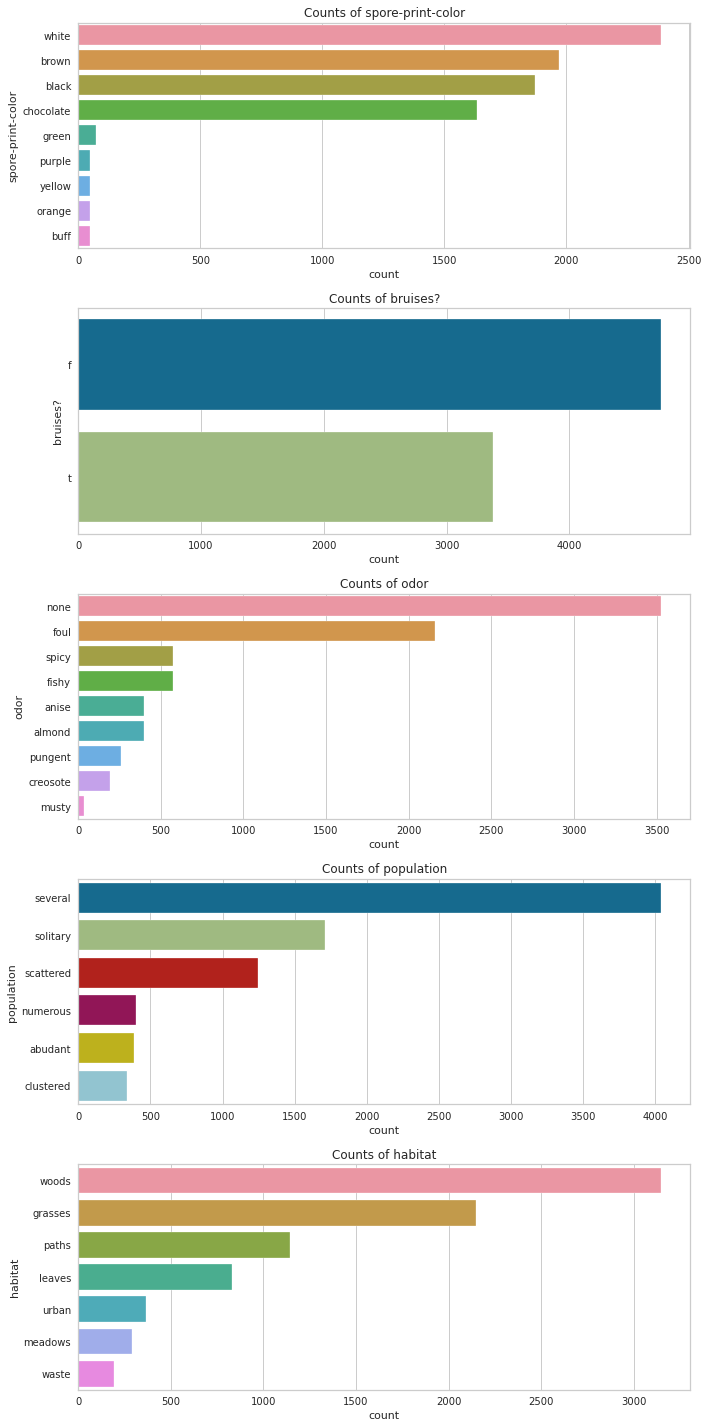

In [21]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig = cat_plot(mush_eda, general_features)

fig.show()

### Bivariate Analysis

### Missing Value Analysis

## Data Preparation

## Modelling

### Baseline Model

### Logistic Regression

### Decision Tree

### Random Forests

## Model Evaluation

## Model Improvement

### Categorical Encoding Methodology

### Feature Selection

### Selecting Via 

### Hyperparameter Tuning

## Final Model

### Model Evaluation

### Feature Importances

## Summary